In [1]:
# ISSUE

'''
    Target shape change garna milxa hola study
'''

'\n    Target shape change garna milxa hola study\n'

# Tunable Parameters are here

In [15]:
# Tunable Parameters
epochs = 5
batch_size = 8
learning_rate=0.001
# Define target shape for resizing
target_shape = (54, 54, 38)

### This code checks how many GPU devices TensorFlow can detect on your system and prints that number.

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

Num GPUs Available:  0


# All imports

In [4]:
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.layers import Conv3D, Conv3DTranspose, Add, Input, Cropping3D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from scipy.ndimage import zoom  # For resizing images
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib.widgets import Slider
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display
from tensorflow.keras.models import load_model
from scipy.ndimage import zoom
from matplotlib.colors import ListedColormap
from nilearn import plotting
from ipywidgets import interact, widgets


# Path to dataset

In [5]:
# Paths to dataset
image_path = r"C:\Users\Praful\OneDrive\Desktop\Mona\DataSet\IBSR_Img"
label_path = r"C:\Users\Praful\OneDrive\Desktop\Mona\DataSet\IBSR_Mask"

# Loading the Files

In [6]:
# Load file names
image_files = sorted(os.listdir(image_path))
label_files = sorted(os.listdir(label_path))

for img_file, lbl_file in zip(image_files, label_files):
    img = nib.load(os.path.join(image_path, img_file))
    lbl = nib.load(os.path.join(label_path, lbl_file))

# Train, Test and Validation

In [7]:
# Split data (train/test)
train_img, test_img, train_lbl, test_lbl = train_test_split(image_files, label_files, test_size=0.2, random_state=42)

# Then split the train set into train and validation
train_img, val_img, train_lbl, val_lbl = train_test_split(train_img, train_lbl, test_size=0.2, random_state=42)

# Checking the label 

In [8]:
label_files = sorted(os.listdir(label_path))
# Choose one file (e.g., the first one)
sample_label_file = os.path.join(label_path, label_files[0])
label_data = nib.load(sample_label_file).get_fdata()
unique_labels = np.unique(label_data)

print("Unique label values in sample file:", unique_labels)


Unique label values in sample file: [0. 1. 2. 3.]


### The color bar should reflect values: 0 (background), 1 (CSF), 2 (GM), 3 (WM).

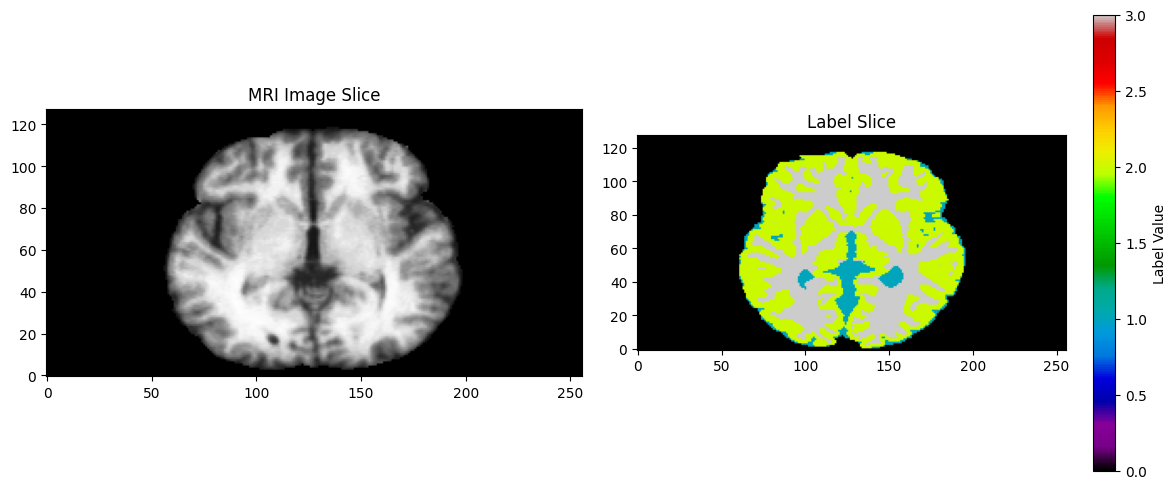

In [9]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os

# Load sample image and label
img_file = os.path.join(image_path, image_files[0])
lbl_file = os.path.join(label_path, label_files[0])

img = nib.load(img_file).get_fdata()
lbl = nib.load(lbl_file).get_fdata()

# Make sure they're 3D (remove singleton dimensions if needed)
img = np.squeeze(img)
lbl = np.squeeze(lbl)

# Choose a slice index
slice_index = lbl.shape[2] // 2  # middle slice

# Select 2D slices
img_slice = img[:, :, slice_index]
lbl_slice = lbl[:, :, slice_index]

# Plot them
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("MRI Image Slice")
plt.imshow(img_slice.T, cmap='gray', origin='lower')

plt.subplot(1, 2, 2)
plt.title("Label Slice")
plt.imshow(lbl_slice.T, cmap='nipy_spectral', origin='lower')

plt.colorbar(label="Label Value")
plt.tight_layout()
plt.show()


# Data Generator

In [10]:
class NiftiDataGenerator(Sequence):
    def __init__(self, image_dir, label_dir, image_filenames, label_filenames, batch_size=2, target_shape=(54, 54, 38), num_classes=4):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_filenames = image_filenames
        self.label_filenames = label_filenames
        self.batch_size = batch_size
        self.target_shape = target_shape
        self.num_classes = num_classes

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, idx):
        batch_images = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.label_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        images, labels = [], []
        for img_file, lbl_file in zip(batch_images, batch_labels):
            img_data = nib.load(os.path.join(self.image_dir, img_file)).get_fdata()
            lbl_data = nib.load(os.path.join(self.label_dir, lbl_file)).get_fdata()

            # CHECK ADDED BY MEEEE
            if img_data.ndim == 3:
                img_data = np.expand_dims(img_data, axis=-1)


            # Strip the channel before resizing  MEEEEEEEEEEEEEEEEE (THIS SOLVED AN ISSUE))
            if img_data.ndim == 4 and img_data.shape[-1] == 1:
                img_data = img_data[..., 0]  # (256, 128, 256) from (256, 128, 256, 1)
            if lbl_data.ndim == 4 and lbl_data.shape[-1] == 1:
                lbl_data = lbl_data[..., 0]

            # Compute zoom factors for resizing
            img_zoom = [t / s for s, t in zip(img_data.shape, self.target_shape)]
            lbl_zoom = [t / s for s, t in zip(lbl_data.shape, self.target_shape)]

            img_resized = zoom(img_data, img_zoom, order=1)  # Bilinear interpolation for images
            lbl_resized = zoom(lbl_data, lbl_zoom, order=0)  # Nearest-neighbor for labels

            images.append(img_resized[..., np.newaxis])  # Add channel dim
            # labels.append((lbl_resized > 0).astype(np.uint8)[..., np.newaxis])  # Convert to binary mask

             # 🟢 One-hot encode the resized label (before adding to list) # ADDED MY MEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
            lbl_one_hot = to_categorical(lbl_resized.astype(np.uint8), num_classes=self.num_classes)
            labels.append(lbl_one_hot)  # (54, 54, 38, num_classes)

        return np.array(images), np.array(labels)

# Initialize generators with resized data
train_generator = NiftiDataGenerator(image_path, label_path, train_img, train_lbl, batch_size, target_shape)
val_generator = NiftiDataGenerator(image_path, label_path, val_img, val_lbl, batch_size, target_shape)
test_generator = NiftiDataGenerator(image_path, label_path, test_img, test_lbl, batch_size, target_shape)


# Testing DataLoaders

In [11]:
def check_generator(generator, name="Generator"):
    batch_images, batch_labels = next(iter(generator))
    print(f"--- {name} ---")
    print(f"Images batch shape: {batch_images.shape}")
    print(f"Labels batch shape: {batch_labels.shape}")
    print(f"Images dtype: {batch_images.dtype}")
    print(f"Labels dtype: {batch_labels.dtype}")
    print(f"Sample image min/max: {batch_images.min()}/{batch_images.max()}")
    print(f"Sample label unique values: {np.unique(batch_labels)}")
    print()

# Usage
check_generator(train_generator, "Train Generator")
check_generator(val_generator, "Validation Generator")
check_generator(test_generator, "Test Generator")

--- Train Generator ---
Images batch shape: (8, 54, 54, 38, 1)
Labels batch shape: (8, 54, 54, 38, 4)
Images dtype: float64
Labels dtype: float64
Sample image min/max: 0.0/68.30468044075666
Sample label unique values: [0. 1.]

--- Validation Generator ---
Images batch shape: (3, 54, 54, 38, 1)
Labels batch shape: (3, 54, 54, 38, 4)
Images dtype: float64
Labels dtype: float64
Sample image min/max: 0.0/73.24345393464058
Sample label unique values: [0. 1.]

--- Test Generator ---
Images batch shape: (4, 54, 54, 38, 1)
Labels batch shape: (4, 54, 54, 38, 4)
Images dtype: float64
Labels dtype: float64
Sample image min/max: 0.0/69.74685437412754
Sample label unique values: [0. 1.]



# V-Net

In [12]:
# Define V-Net architecture
def vnet_block(x, filters):
    res = Conv3D(filters, (3, 3, 3), padding="same", activation="relu")(x)
    res = Conv3D(filters, (3, 3, 3), padding="same", activation="relu")(res)
    return Add()([x, res])


# AVERAGE DICE COEFFICIENT AND MEAN IOU FUNCTIONS

In [13]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    num_classes = tf.shape(y_pred)[-1]
    dice = 0.0

    def compute_class_dice(i, total):
        y_true_c = y_true[..., i]
        y_pred_c = y_pred[..., i]

        intersection = K.sum(y_true_c * y_pred_c)
        union = K.sum(y_true_c) + K.sum(y_pred_c)

        class_dice = (2.0 * intersection + smooth) / (union + smooth)
        return total + class_dice

    dice = tf.foldl(lambda total, i: compute_class_dice(i, total),
                    tf.range(num_classes), initializer=0.0)

    return dice / tf.cast(num_classes, tf.float32)

def mean_iou(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    num_classes = tf.shape(y_pred)[-1]

    def compute_class_iou(i, total):
        y_true_c = y_true[..., i]
        y_pred_c = y_pred[..., i]

        intersection = K.sum(y_true_c * y_pred_c)
        union = K.sum(y_true_c) + K.sum(y_pred_c) - intersection

        class_iou = (intersection + smooth) / (union + smooth)
        return total + class_iou

    iou = tf.foldl(lambda total, i: compute_class_iou(i, total),
                   tf.range(num_classes), initializer=0.0)

    return iou / tf.cast(num_classes, tf.float32)

# INDIVIDUAL DICE COEFFICIENT AND MEAN IOU FUNCTIONS

In [14]:
def dice_per_class(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    num_classes = tf.shape(y_pred)[-1]

    def compute_class_dice(i):
        y_true_c = y_true[..., i]
        y_pred_c = y_pred[..., i]

        intersection = tf.reduce_sum(y_true_c * y_pred_c)
        union = tf.reduce_sum(y_true_c) + tf.reduce_sum(y_pred_c)

        dice_score = (2.0 * intersection + smooth) / (union + smooth)
        tf.print("Dice score for class", i, ":", dice_score)
        return dice_score

    dice_scores = tf.map_fn(compute_class_dice, tf.range(num_classes), dtype=tf.float32)

    return dice_scores  # returns tensor with dice per class

def mean_iou_per_class(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    num_classes = tf.shape(y_pred)[-1]

    def compute_class_iou(i):
        y_true_c = y_true[..., i]
        y_pred_c = y_pred[..., i]

        intersection = tf.reduce_sum(y_true_c * y_pred_c)
        union = tf.reduce_sum(y_true_c) + tf.reduce_sum(y_pred_c) - intersection

        iou_score = (intersection + smooth) / (union + smooth)
        tf.print("mIoU score for class", i, ":", iou_score)
        return iou_score

    iou_scores = tf.map_fn(compute_class_iou, tf.range(num_classes), dtype=tf.float32)

    return iou_scores  # returns tensor with iou per class

# 3D vnet architecture

In [17]:
def build_3d_vnet(input_shape=(54, 54, 38, 1)):
    inputs = Input(input_shape)

    # Encoder
    e1 = Conv3D(16, (3, 3, 3), activation="relu", padding="same")(inputs)
    e1 = vnet_block(e1, 16)
    e2 = Conv3D(32, (3, 3, 3), strides=2, padding="same", activation="relu")(e1)
    e2 = vnet_block(e2, 32)
    e3 = Conv3D(64, (3, 3, 3), strides=2, padding="same", activation="relu")(e2)
    e3 = vnet_block(e3, 64)

    # Bottleneck
    b = vnet_block(e3, 64)  # Ensure bottleneck matches e3 (64 filters)

    # Decoder
    d3 = Conv3DTranspose(64, (3, 3, 3), strides=2, padding="same", activation="relu")(b)
    d3 = Cropping3D(cropping=((0, 0), (0, 0), (0, 0)))(e3)  # Crop encoder output to match decoder
    d3 = Add()([d3, e3])
    d3 = vnet_block(d3, 64)
    d2 = Conv3DTranspose(32, (3, 3, 3), strides=2, padding="same", activation="relu")(d3)
    d2 = Cropping3D(cropping=((0, 0), (0, 0), (0, 0)))(e2)  # Crop encoder output to match decoder
    d2 = Add()([d2, e2])
    d2 = vnet_block(d2, 32)
    d1 = Conv3DTranspose(16, (3, 3, 3), strides=2, padding="same", activation="relu")(d2)
    d1 = Cropping3D(cropping=((0, 0), (0, 0), (0, 0)))(e1)  # Crop encoder output to match decoder
    d1 = Add()([d1, e1])
    d1 = vnet_block(d1, 16)
    # outputs = Conv3D(1, (1, 1, 1), activation="sigmoid")(d1) # NUMBER OF CLASS OUTPUT LAYER MA HO. THIS IS FOR BINARY SEGMENTATION NOW I WILL COMMENT THIS AND ADD FOR 4 CLASSES
    num_classes = 4 # MEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
    outputs = Conv3D(num_classes, (1, 1, 1), activation="softmax")(d1) # MEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE

    model = Model(inputs, outputs)
    # model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy']) # THIS IS FOR BINARY SEGMENTATION NOW I WILL COMMENT THIS AND ADD FOR 4 CLASSES
    model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy',dice_coef,mean_iou])  # MEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
    return model

# learning rate is added by me 


# Training

In [18]:
# Build model with fixed input shape
print("Building V-Net...")
model = build_3d_vnet(input_shape=target_shape + (1,))

# Train model
print("Starting training...")
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator)

Building V-Net...
Starting training...


c:\Users\Praful\OneDrive\Desktop\Choreko\monalisa\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6895 - dice_coef: 0.1603 - loss: 3.5691 - mean_iou: 0.0959 - val_accuracy: 0.7961 - val_dice_coef: 0.1672 - val_loss: 2.1191 - val_mean_iou: 0.0993
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 951ms/step - accuracy: 0.7810 - dice_coef: 0.1626 - loss: 2.2434 - mean_iou: 0.0971 - val_accuracy: 0.8558 - val_dice_coef: 0.1576 - val_loss: 1.9122 - val_mean_iou: 0.0957
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 920ms/step - accuracy: 0.8505 - dice_coef: 0.1655 - loss: 1.8458 - mean_iou: 0.1013 - val_accuracy: 0.8953 - val_dice_coef: 0.1932 - val_loss: 1.6484 - val_mean_iou: 0.1197
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.8756 - dice_coef: 0.1903 - loss: 1.7054 - mean_iou: 0.1172 - val_accuracy: 0.9054 - val_dice_coef: 0.2100 - val_loss: 1.4671 - val_mean_iou: 0.1301
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.8838 - dice_coef: 0.2033 - loss: 1.5634 - mean_iou: 0.1255 - val_accuracy: 0.9091 - val_dice_coef: 0.2

# Plotting Graph

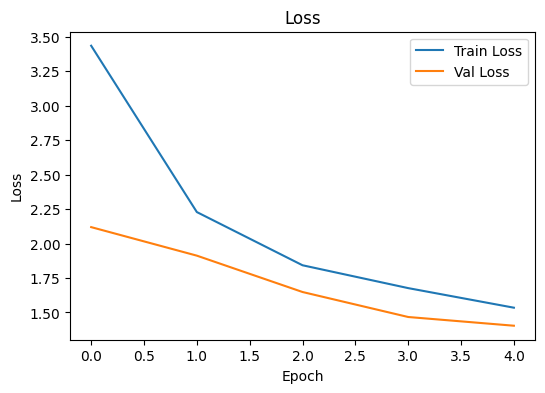

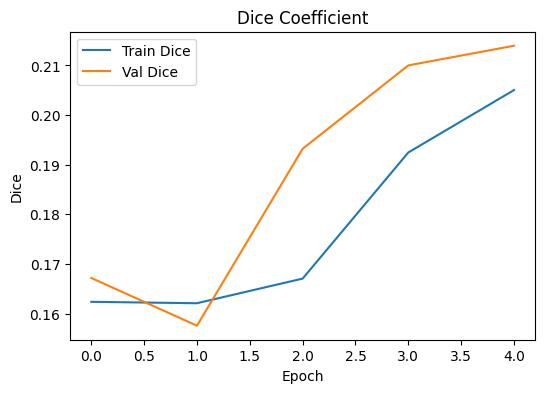

In [19]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation Dice Coefficient
plt.figure(figsize=(6, 4))
plt.plot(history.history['dice_coef'], label='Train Dice')
plt.plot(history.history['val_dice_coef'], label='Val Dice')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()
plt.show()


# TEST CODE

In [ ]:
# Initialize variables to accumulate dice scores and count batches
total_dice = None
num_batches = 0

for test_images, test_labels in test_generator:
    preds = model.predict(test_images)
    pred_labels = tf.one_hot(tf.argmax(preds, axis=-1), depth=preds.shape[-1])
    
    dice_scores = dice_per_class(test_labels, pred_labels).numpy()
    
    if total_dice is None:
        total_dice = dice_scores
    else:
        total_dice += dice_scores
    
    num_batches += 1
    
    # Optional: break if you want to stop after one epoch (if generator is infinite)
    if num_batches == len(test_generator):
        break

# Average dice score per class over all test batches
avg_dice = total_dice / num_batches

print("Average Dice scores per class over all test images:")
for i, score in enumerate(avg_dice):
    print(f"Class {i}: {score:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Dice score for class 0 : 0.971530795
Dice score for class 1 : 0.0739910305
Dice score for class 2 : 0.378232419
Dice score for class 3 : 0.412283659
Average Dice scores per class over all test images:
Class 0: 0.9715
Class 1: 0.0740
Class 2: 0.3782
Class 3: 0.4123


In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 54, 54,    │          0 │ -                 │
│ (InputLayer)        │ 38, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 54, 54,    │        448 │ input_layer[0][0] │
│                     │ 38, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 54, 54,    │      6,928 │ conv3d[0][0]      │
│                     │ 38, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 54, 54,    │      6,928 │ conv3d_1[0][0]    │
│                     │ 38, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 54, 54,    │          0 │ conv3d[0][0],     │
│                     │ 38, 16)           │            │ conv3d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cropping3d_2        │ (None, 54, 54,    │          0 │ add[0][0]         │
│ (Cropping3D)        │ 38, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 54, 54,    │          0 │ cropping3d_2[0][… │
│                     │ 38, 16)           │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_15 (Conv3D)  │ (None, 54, 54,    │      6,928 │ add_8[0][0]       │
│                     │ 38, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_16 (Conv3D)  │ (None, 54, 54,    │      6,928 │ conv3d_15[0][0]   │
│                     │ 38, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 54, 54,    │          0 │ add_8[0][0],      │
│                     │ 38, 16)           │            │ conv3d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_17 (Conv3D)  │ (None, 54, 54,    │         68 │ add_9[0][0]       │
│                     │ 38, 4)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,686 (330.81 KB)

 Trainable params: 28,228 (110.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 56,458 (220.54 KB)

# Saving the model

In [21]:
model.save(r"C:\Users\Praful\OneDrive\Desktop\Choreko\3d_vnet_model.h5")


# Visualization

You often visualize data before training to verify it’s loaded correctly
But visualizing after training lets you evaluate the outcome of your efforts—did the model learn what it’s supposed to?

In [22]:
def load_and_preprocess(nifti_file_path):
    """Load a NIfTI file and return its data as a numpy array"""
    nifti_img = nib.load(nifti_file_path)
    nifti_data = nifti_img.get_fdata()
    return nifti_data, nifti_img.affine

'''
    This function loads a NIfTI medical image file from the given path, 
    extracts its image data as a NumPy array, 
    and returns both the data and the image’s spatial transformation matrix (affine).
'''

'\n    This function loads a NIfTI medical image file from the given path, \n    extracts its image data as a NumPy array, \n    and returns both the data and the image’s spatial transformation matrix (affine).\n'

# Visualization of 3D data

In [23]:
def visualize_3d_data(image_data, label_data=None):
    """Visualize 3D data with sliders for navigating through slices"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Get the dimensions
    x_max, y_max, z_max = image_data.shape
    
    # Create normalized image data for display
    norm_image = (image_data - image_data.min()) / (image_data.max() - image_data.min())
    
    # Initial slice indices (middle of the volume)
    x_slice, y_slice, z_slice = x_max // 2, y_max // 2, z_max // 2
    
    # Display initial slices
    ax1_img = axes[0].imshow(norm_image[x_slice, :, :].T, cmap='gray')
    axes[0].set_title(f'Sagittal Slice ({x_slice}/{x_max})')
    axes[0].set_ylabel('Z axis')
    axes[0].set_xlabel('Y axis')
    
    ax2_img = axes[1].imshow(norm_image[:, y_slice, :].T, cmap='gray')
    axes[1].set_title(f'Coronal Slice ({y_slice}/{y_max})')
    axes[1].set_ylabel('Z axis')
    axes[1].set_xlabel('X axis')
    
    ax3_img = axes[2].imshow(norm_image[:, :, z_slice], cmap='gray')
    axes[2].set_title(f'Axial Slice ({z_slice}/{z_max})')
    axes[2].set_ylabel('Y axis')
    axes[2].set_xlabel('X axis')
    
    # If we have label data, overlay it with transparency
    if label_data is not None:
        ax1_label = axes[0].imshow(label_data[x_slice, :, :].T, cmap='hot', alpha=0.3)
        ax2_label = axes[1].imshow(label_data[:, y_slice, :].T, cmap='hot', alpha=0.3)
        ax3_label = axes[2].imshow(label_data[:, :, z_slice], cmap='hot', alpha=0.3)
    
    # Add sliders for navigation
    ax_x = plt.axes([0.15, 0.01, 0.65, 0.03])
    ax_y = plt.axes([0.15, 0.05, 0.65, 0.03])
    ax_z = plt.axes([0.15, 0.09, 0.65, 0.03])
    
    slider_x = Slider(ax_x, 'Sagittal Slice', 0, x_max-1, valinit=x_slice, valstep=1)
    slider_y = Slider(ax_y, 'Coronal Slice', 0, y_max-1, valinit=y_slice, valstep=1)
    slider_z = Slider(ax_z, 'Axial Slice', 0, z_max-1, valinit=z_slice, valstep=1)
    
    def update(val):
        x_slice = int(slider_x.val)
        y_slice = int(slider_y.val)
        z_slice = int(slider_z.val)
        
        ax1_img.set_data(norm_image[x_slice, :, :].T)
        axes[0].set_title(f'Sagittal Slice ({x_slice}/{x_max})')
        
        ax2_img.set_data(norm_image[:, y_slice, :].T)
        axes[1].set_title(f'Coronal Slice ({y_slice}/{y_max})')
        
        ax3_img.set_data(norm_image[:, :, z_slice])
        axes[2].set_title(f'Axial Slice ({z_slice}/{z_max})')
        
        if label_data is not None:
            ax1_label.set_data(label_data[x_slice, :, :].T)
            ax2_label.set_data(label_data[:, y_slice, :].T)
            ax3_label.set_data(label_data[:, :, z_slice])
        
        fig.canvas.draw_idle()
    
    slider_x.on_changed(update)
    slider_y.on_changed(update)
    slider_z.on_changed(update)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)
    plt.show()

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.cm as cm

def visualize_3d_multiclass_surface(label_data, num_classes=4):
    """Visualize a 3D surface from multi-class label data"""
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    colors = cm.get_cmap('tab10', num_classes)  # Get a colormap with `num_classes` distinct colors

    for class_id in range(1, num_classes):  # Skip background (class 0)
        mask = label_data == class_id
        x, y, z = np.where(mask)

        # Downsample for performance if too many points
        downsample_ratio = len(x) // 5000 + 1
        x = x[::downsample_ratio]
        y = y[::downsample_ratio]
        z = z[::downsample_ratio]

        ax.scatter(x, y, z, c=[colors(class_id)], label=f'Class {class_id}', marker='.', alpha=0.5, s=1)

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Visualization of Multi-class Segmentation')
    ax.legend()
    plt.tight_layout()
    plt.show()


In [25]:
def visualize_brain_dataset(image_file, label_file, num_classes=4):
    """Load and visualize a brain image and its multiclass segmentation"""
    print(f"Loading image: {image_file}")
    image_data, _ = load_and_preprocess(image_file)
    
    print(f"Loading label: {label_file}")
    label_data, _ = load_and_preprocess(label_file)

    # Remove singleton channel dimension if present (e.g., (H, W, D, 1))
    if label_data.ndim == 4 and label_data.shape[-1] == 1:
        label_data = np.squeeze(label_data, axis=-1)
    
    print("Image shape:", image_data.shape)
    print("Label shape:", label_data.shape)
    
    # Visualize slices with label overlay
    print("Displaying slice viewer...")
    visualize_3d_data(image_data, label_data)
    
    # Optionally visualize 3D surface
    response = input("Would you like to visualize the 3D surface? (y/n): ")
    if response.lower() == 'y':
        print("Generating 3D surface visualization...")
        visualize_3d_multiclass_surface(label_data, num_classes=num_classes)


Found 18 image files and 18 label files
Sample 1/18
Loading image: C:\Users\Praful\OneDrive\Desktop\Mona\DataSet\IBSR_Img\IBSR_01_ana_strip.nii
Loading label: C:\Users\Praful\OneDrive\Desktop\Mona\DataSet\IBSR_Mask\IBSR_10_segTRI_fill_ana.nii
Image shape: (256, 128, 256)
Label shape: (256, 128, 256)
Displaying slice viewer...


C:\Users\Praful\AppData\Local\Temp\ipykernel_31816\934551049.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


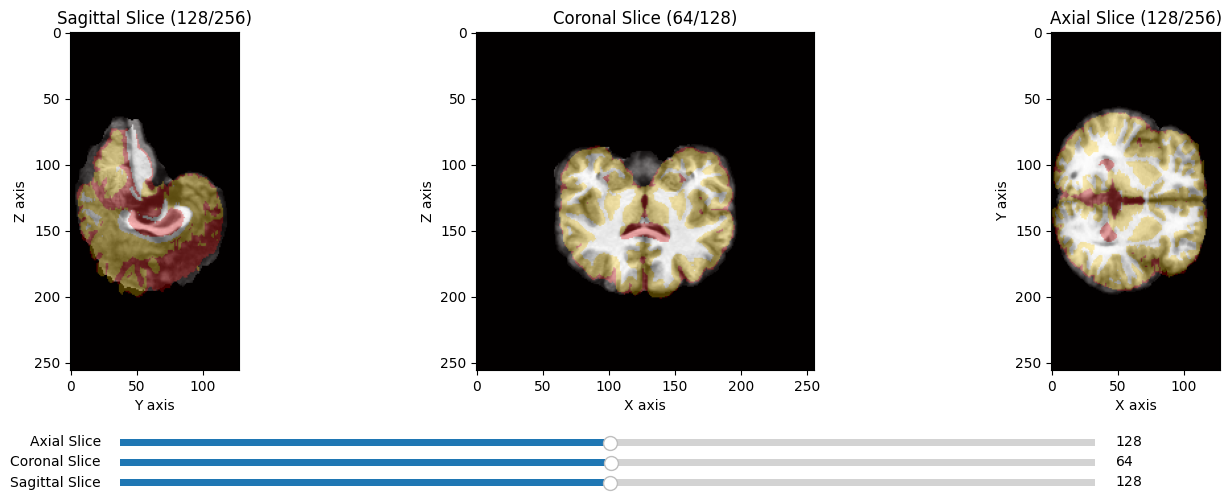

In [26]:
# Example visualization function for all dataset samples
def explore_dataset(image_path, label_path):
    """Interactive function to explore all samples in the dataset"""
    image_files = sorted([os.path.join(image_path, f) for f in os.listdir(image_path) if f.endswith('.nii') or f.endswith('.nii.gz')])
    label_files = sorted([os.path.join(label_path, f) for f in os.listdir(label_path) if f.endswith('.nii') or f.endswith('.nii.gz')])
    
    print(f"Found {len(image_files)} image files and {len(label_files)} label files")
    
    if len(image_files) != len(label_files):
        print("Warning: Number of image files doesn't match number of label files")
    
    sample_pairs = list(zip(image_files, label_files))
    
    for i, (img_file, lbl_file) in enumerate(sample_pairs):
        print(f"Sample {i+1}/{len(sample_pairs)}")
        visualize_brain_dataset(img_file, lbl_file)
        
        if i < len(sample_pairs) - 1:
            response = input("Continue to next sample? (y/n): ")
            if response.lower() != 'y':
                break

explore_dataset(image_path, label_path)

# Or to visualize a specific pair:
# image_file = os.path.join(image_path, "first_image.nii.gz")
# label_file = os.path.join(label_path, "first_label.nii.gz")
# visualize_brain_dataset(image_file, label_file)

This code loads the first image and its corresponding label file from specified directories, then uses Nilearn’s plot_roi function to overlay and display the label (region of interest) on top of the background image in orthogonal (axial, sagittal, coronal) views.

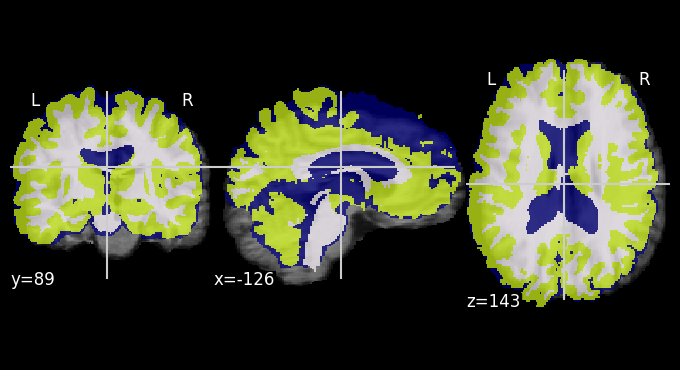

In [27]:
# Get the first image and label file
image_files = sorted(os.listdir(image_path))
label_files = sorted(os.listdir(label_path))

image_file = os.path.join(image_path, image_files[0])
label_file = os.path.join(label_path, label_files[0])

# Use the nilearn visualization
from nilearn import plotting
plotting.plot_roi(label_file, bg_img=image_file, display_mode='ortho')
plt.show()

# Loading the save model

In [28]:
# Path to your saved model
model_path = r"C:\Users\Praful\OneDrive\Desktop\Choreko\3d_vnet_model.h5"

# Load the saved model
model = load_model(model_path)

# Print model summary to verify it loaded correctly
print("Model loaded successfully!")
print(model.summary())

Model loaded successfully!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 54, 54,    │          0 │ -                 │
│ (InputLayer)        │ 38, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 54, 54,    │        448 │ input_layer[0][0] │
│                     │ 38, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 54, 54,    │      6,928 │ conv3d[0][0]      │
│                     │ 38, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 54, 54,    │      6,928 │ conv3d_1[0][0]    │
│                     │ 38, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 54, 54,    │          0 │ conv3d[0][0],     │
│                     │ 38, 16)           │            │ conv3d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cropping3d_2        │ (None, 54, 54,    │          0 │ add[0][0]         │
│ (Cropping3D)        │ 38, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 54, 54,    │          0 │ cropping3d_2[0][… │
│                     │ 38, 16)           │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_15 (Conv3D)  │ (None, 54, 54,    │      6,928 │ add_8[0][0]       │
│                     │ 38, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_16 (Conv3D)  │ (None, 54, 54,    │      6,928 │ conv3d_15[0][0]   │
│                     │ 38, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 54, 54,    │          0 │ add_8[0][0],      │
│                     │ 38, 16)           │            │ conv3d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_17 (Conv3D)  │ (None, 54, 54,    │         68 │ add_9[0][0]       │
│                     │ 38, 4)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 28,230 (110.28 KB)

 Trainable params: 28,228 (110.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None


# Starting to create prediction.nii

In [29]:
# Function to preprocess an image for the model
def preprocess_image(nifti_file, target_shape=(54, 54, 38)):
    """Load and preprocess a NIfTI file for model inference"""
    # Load NIfTI file
    nifti_img = nib.load(nifti_file)
    nifti_data = nifti_img.get_fdata()
    
    # Calculate zoom factors
    zoom_factors = [t / s for s, t in zip(nifti_data.shape, target_shape)]
    
    # Resize image to target shape
    img_resized = zoom(nifti_data, zoom_factors, order=1)
    
    # Add batch and channel dimensions
    img_input = np.expand_dims(np.expand_dims(img_resized, axis=0), axis=-1)
    
    return img_input, nifti_img.affine, nifti_data.shape

In [30]:
'''
# Function to make a prediction and convert back to original size
def predict_segmentation(model, nifti_file, target_shape=(54, 54, 38)):
    """Predict segmentation and return it in original image space"""
    # Preprocess the image
    img_input, affine, orig_shape = preprocess_image(nifti_file, target_shape)
    
    # Make prediction
    prediction = model.predict(img_input)[0, ..., 0]
    
    # Resize prediction back to original dimensions
    inverse_zoom = [s / t for s, t in zip(orig_shape, target_shape)]
    pred_orig_size = zoom(prediction, inverse_zoom, order=0)
    
    # Threshold prediction (binary segmentation)
    pred_binary = (pred_orig_size > 0.5).astype(np.uint8)
    
    return pred_binary, affine
'''
    
def predict_segmentation_multiclass(model, nifti_file, target_shape=(54, 54, 38)):
    """Predict multi-class segmentation and return label map in original image space"""
    # Preprocess the image
    img_input, affine, orig_shape = preprocess_image(nifti_file, target_shape)
    
    # Make prediction: shape (x, y, z, num_classes)
    prediction = model.predict(img_input)[0]  # remove batch dimension
    
    # prediction shape example: (54, 54, 38, 4)
    
    # For multi-class, take argmax across channels (last axis)
    pred_labels = np.argmax(prediction, axis=-1)  # shape: (54, 54, 38)
    
    # Resize prediction back to original dimensions using nearest neighbor interpolation
    inverse_zoom = [s / t for s, t in zip(orig_shape, target_shape)]
    pred_orig_size = zoom(pred_labels, inverse_zoom, order=0)  # order=0 for labels
    
    # Return predicted labels and affine
    return pred_orig_size.astype(np.uint8), affine

Running inference on: C:\Users\Praful\OneDrive\Desktop\Mona\DataSet\IBSR_Img\IBSR_01_ana_strip.nii
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Prediction saved to C:\Users\Praful\OneDrive\Desktop\Choreko\prediction.nii.gz
Inference completed successfully!


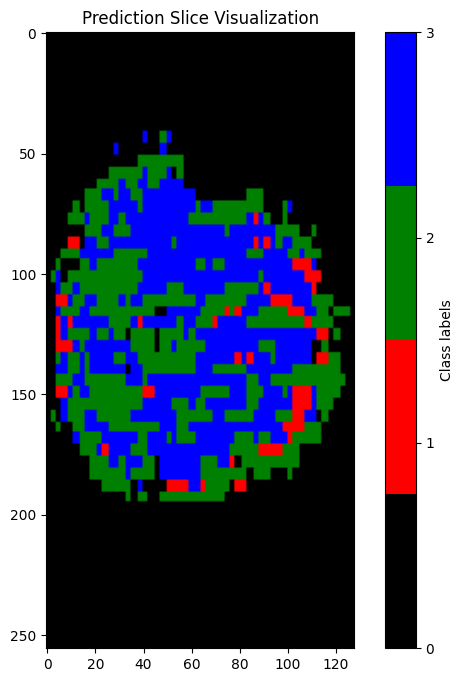

In [31]:
# Function to save a prediction as a NIfTI file
def save_prediction(prediction, affine, output_file):
    """Save a prediction array as a NIfTI file"""
    pred_nifti = nib.Nifti1Image(prediction, affine)
    nib.save(pred_nifti, output_file)
    print(f"Prediction saved to {output_file}")

# Example: Make a prediction on a test image
def run_inference_example():
    # Get a list of image files
    image_files = sorted(os.listdir(image_path))
    
    if len(image_files) == 0:
        print("No image files found!")
        return
    
    # Select the first image file (or any other file you want)
    test_file = os.path.join(image_path, image_files[0])
    print(f"Running inference on: {test_file}")
    
    # Make prediction
    prediction, affine = predict_segmentation_multiclass(model, test_file, target_shape)
    
    # Save prediction
    output_file = r"C:\Users\Praful\OneDrive\Desktop\Choreko\prediction.nii.gz"
    save_prediction(prediction, affine, output_file)
    print("Inference completed successfully!")
    return output_file
    
# Run inference and get saved prediction path
output_file = run_inference_example()

# Now visualize the saved prediction
if output_file:
    pred_nifti = nib.load(output_file)
    pred_data = pred_nifti.get_fdata()
    
    # Create a ListedColormap with distinct colors for 4 classes
    colors = ['black', 'red', 'green', 'blue']
    cmap = ListedColormap(colors)
    
    slice_data = pred_data[:, :, pred_data.shape[2] // 2].astype(int)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(slice_data, cmap=cmap, vmin=0, vmax=3)
    plt.colorbar(ticks=range(4), label='Class labels')
    plt.title('Prediction Slice Visualization')
    plt.show()

In [32]:
'''
def visualize_with_nilearn(image_file, label_file=None, display_mode='ortho', colormap='gray'):
    """
    Visualize NIfTI files using nilearn's plotting functions
    
    Parameters:
    -----------
    image_file : str
        Path to the NIfTI image file (.nii or .nii.gz)
    label_file : str, optional
        Path to the segmentation label file (.nii or .nii.gz)
    display_mode : str, optional
        Display mode: 'ortho', 'x', 'y', 'z', 'yx', 'xz', 'yz'
    colormap : str, optional
        Colormap for the background image
    """
    # Load image
    img = nib.load(image_file)
    
    # Create the visualization
    if label_file is not None:
        # Load label
        label_img = nib.load(label_file)
        
        # Create an overlay visualization
        display = plotting.plot_roi(
            label_img, 
            bg_img=img,
            display_mode=display_mode,
            colorbar=True,
            cmap='hot',
            alpha=0.7,
            bg_vmin=np.percentile(img.get_fdata(), 5),
            bg_vmax=np.percentile(img.get_fdata(), 95),
            title=f"Image with Segmentation Overlay\nDisplayMode: {display_mode}"
        )
    else:
        # Display just the image
        display = plotting.plot_anat(
            img,
            display_mode=display_mode,
            colorbar=True,
            cmap=colormap,
            vmin=np.percentile(img.get_fdata(), 5),
            vmax=np.percentile(img.get_fdata(), 95),
            title=f"3D Image\nDisplayMode: {display_mode}"
        )
    
    plt.show()
    return display
'''
import numpy as np
import nibabel as nib
from nilearn import plotting
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def visualize_multiclass_with_nilearn(image_file, label_file=None, display_mode='ortho', colormap='gray'):
    """
    Visualize NIfTI files with multi-class segmentation overlay (4 classes).
    
    Parameters:
    -----------
    image_file : str
        Path to the NIfTI image file (.nii or .nii.gz)
    label_file : str, optional
        Path to the multi-class segmentation label file (.nii or .nii.gz)
    display_mode : str, optional
        Display mode: 'ortho', 'x', 'y', 'z', 'yx', 'xz', 'yz'
    colormap : str, optional
        Colormap for the background anatomical image
    """
    # Load the anatomical image
    img = nib.load(image_file)

    if label_file is not None:
        # Load the label image
        label_img = nib.load(label_file)

        # Define a discrete colormap for 4 classes (including background)
        # Background class 0 is transparent, classes 1-3 get distinct colors
        colors = ['black', 'red', 'green', 'blue']  # Customize colors per class
        cmap = ListedColormap(colors)

        # Plot anatomical image as background
        display = plotting.plot_anat(
            img,
            display_mode=display_mode,
            colorbar=True,
            cmap=colormap,
            vmin=np.percentile(img.get_fdata(), 5),
            vmax=np.percentile(img.get_fdata(), 95),
            title=f"Image with Multi-class Segmentation Overlay\nDisplayMode: {display_mode}"
        )

        # Overlay multi-class label with transparency
        display.add_overlay(label_img, cmap=cmap, alpha=0.5)

    else:
        # Just display anatomical image if no label
        display = plotting.plot_anat(
            img,
            display_mode=display_mode,
            colorbar=True,
            cmap=colormap,
            vmin=np.percentile(img.get_fdata(), 5),
            vmax=np.percentile(img.get_fdata(), 95),
            title=f"3D Image\nDisplayMode: {display_mode}"
        )

    plt.show()
    return display


In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
import matplotlib.colors as mcolors

def interactive_viewer(image_file, label_file=None):
    """
    Interactive viewer for NIfTI files with sliders for 4-class segmentation
    
    Parameters:
    -----------
    image_file : str
        Path to the NIfTI image file (.nii or .nii.gz)
    label_file : str, optional
        Path to the segmentation label file (.nii or .nii.gz)
    """
    # Load image data
    img = nib.load(image_file)
    img_data = img.get_fdata()
    
    # Load label data if provided
    if label_file is not None:
        label_img = nib.load(label_file)
        label_data = label_img.get_fdata()
    else:
        label_data = None
    
    # Define a discrete colormap for 4 classes (0,1,2,3)
    cmap = mcolors.ListedColormap(['black', 'red', 'green', 'blue'])
    class_names = ['Background', 'Class 1', 'Class 2', 'Class 3']

    def view_slice(axis, slice_idx, opacity=0.5):
        plt.figure(figsize=(10, 8))
        
        if axis == 'x':
            img_slice = img_data[slice_idx, :, :].T
            label_slice = label_data[slice_idx, :, :].T if label_data is not None else None
            xlabel, ylabel = 'Y axis', 'Z axis'
            title = f'Sagittal Slice {slice_idx}'
        elif axis == 'y':
            img_slice = img_data[:, slice_idx, :].T
            label_slice = label_data[:, slice_idx, :].T if label_data is not None else None
            xlabel, ylabel = 'X axis', 'Z axis'
            title = f'Coronal Slice {slice_idx}'
        else:  # axis == 'z'
            img_slice = img_data[:, :, slice_idx]
            label_slice = label_data[:, :, slice_idx] if label_data is not None else None
            xlabel, ylabel = 'X axis', 'Y axis'
            title = f'Axial Slice {slice_idx}'
        
        plt.imshow(img_slice, cmap='gray', origin='lower')
        
        if label_slice is not None:
            # Overlay segmentation with discrete colormap, fixed vmin/vmax
            plt.imshow(label_slice, cmap=cmap, alpha=opacity, origin='lower', vmin=0, vmax=3)
            
            # Add a custom legend for classes
            import matplotlib.patches as mpatches
            patches = [mpatches.Patch(color=cmap(i), label=class_names[i]) for i in range(4)]
            plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.tight_layout()
        plt.show()
    
    x_max, y_max, z_max = img_data.shape
    
    interact(
        view_slice,
        axis=widgets.Dropdown(options=['x', 'y', 'z'], value='z', description='Axis:'),
        slice_idx=widgets.IntSlider(min=0, max=max(x_max, y_max, z_max) - 1, step=1, value=z_max // 2, description='Slice:'),
        opacity=widgets.FloatSlider(min=0, max=1, step=0.1, value=0.5, description='Overlay:')
    )


In [ ]:

def explore_brain_dataset(image_dir, label_dir):
    """
    Explore brain dataset by interactively selecting image-label pairs and visualizing with interactive_viewer.
    
    Parameters:
    -----------
    image_dir : str
        Directory containing image NIfTI files (.nii or .nii.gz)
    label_dir : str
        Directory containing label NIfTI files (.nii or .nii.gz)
    """
    # List image and label files, sorted alphabetically
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.nii') or f.endswith('.nii.gz')])
    label_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.nii') or f.endswith('.nii.gz')])
    
    # Match files by name (assumes corresponding names)
    pairs = []
    for img_name in image_files:
        # Try to find matching label file by exact name or replace image prefix with label prefix
        if img_name in label_files:
            pairs.append((os.path.join(image_dir, img_name), os.path.join(label_dir, img_name)))
        else:
            # If no exact match, append image with label_file=None (you can customize)
            pairs.append((os.path.join(image_dir, img_name), None))
    
    if not pairs:
        print("No matching image-label pairs found.")
        return
    
    # Dropdown for selecting image-label pair
    options = [(os.path.basename(img), (img, lbl)) for img, lbl in pairs]
    dropdown = widgets.Dropdown(options=options, description='Select sample:', style={'description_width': 'initial'}, layout={'width': '50%'})
    
    output = widgets.Output()
    
    def on_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            img_path, lbl_path = change['new']
            output.clear_output(wait=True)
            with output:
                interactive_viewer(img_path, lbl_path)
    
    dropdown.observe(on_change)
    
    display(dropdown, output)
    
    # Show first sample by default
    with output:
        interactive_viewer(pairs[0][0], pairs[0][1])

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn import plotting
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

def visualize_model_predictions(image_file, true_label_file, predicted_label_file):
    """
    Visualize 4-class model predictions compared to ground truth
    """

    # Load data
    img = nib.load(image_file)
    true_label = nib.load(true_label_file)
    pred_label = nib.load(predicted_label_file)

    # Extract and squeeze label data arrays ✅
    true_data = np.squeeze(true_label.get_fdata())
    pred_data = np.squeeze(pred_label.get_fdata())

    # Define discrete colormap for 4 classes
    cmap = mcolors.ListedColormap(['black', 'red', 'green', 'blue'])
    class_names = ['Background', 'Class 1', 'Class 2', 'Class 3']

    # Create figure and axes
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot original anatomical image
    display1 = plotting.plot_anat(img, figure=fig, axes=axes[0], title="Original Image")

    # Get center slice index along the z-axis
    center_slice = img.shape[2] // 2

    # Plot ground truth with discrete colormap ✅
    axes[1].imshow(img.get_fdata()[:, :, center_slice].T, cmap='gray', origin='lower')
    im1 = axes[1].imshow(true_data[:, :, center_slice].T, cmap=cmap, alpha=0.5, origin='lower', vmin=0, vmax=3)
    axes[1].set_title("Ground Truth Segmentation")

    # Plot prediction with discrete colormap ✅
    axes[2].imshow(img.get_fdata()[:, :, center_slice].T, cmap='gray', origin='lower')
    im2 = axes[2].imshow(pred_data[:, :, center_slice].T, cmap=cmap, alpha=0.5, origin='lower', vmin=0, vmax=3)
    axes[2].set_title("Model Prediction")

    # Add legend for both segmentation plots
    patches = [mpatches.Patch(color=cmap(i), label=class_names[i]) for i in range(4)]
    axes[1].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[2].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


In [40]:
# Example: To convert your model predictions to NIfTI for visualization
def save_prediction_as_nifti(model, image_file, output_file, target_shape=(54, 54, 38)):
    """
    Generate and save model predictions as NIfTI files
    
    Parameters:
    -----------
    model : tensorflow.keras.Model
        Trained segmentation model
    image_file : str
        Path to the input NIfTI image
    output_file : str
        Path to save the prediction NIfTI file
    target_shape : tuple, optional
        Target shape for model input
    """
    from scipy.ndimage import zoom
    
    # Load image
    img = nib.load(image_file)
    img_data = img.get_fdata()
    affine = img.affine
    
    # Resize to model input shape
    orig_shape = img_data.shape
    zoom_factors = [t / s for s, t in zip(orig_shape, target_shape)]
    img_resized = zoom(img_data, zoom_factors, order=1)
    
    # Add batch and channel dimensions
    model_input = np.expand_dims(np.expand_dims(img_resized, axis=0), axis=-1)
    
    # Generate prediction
    prediction = model.predict(model_input)[0]
    pred_labels_resized = np.argmax(prediction, axis=-1).astype(np.uint8)  # shape: (x, y, z)

    # Resize back to original dimensions
    inverse_zoom = [s / t for s, t in zip(orig_shape, target_shape)]
    pred_labels_orig = zoom(pred_labels_resized, inverse_zoom, order=0)
    
    # Save as NIfTI
    pred_nifti = nib.Nifti1Image(pred_labels_orig, affine)
    nib.save(pred_nifti, output_file)
    
    print(f"Prediction saved to {output_file}")


explore_brain_dataset(image_path, label_path)

Dropdown(description='Select sample:', layout=Layout(width='50%'), options=(('IBSR_01_ana_strip.nii', ('C:\\Us…

Output()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction saved to prediction.nii.gz


C:\Users\Praful\AppData\Local\Temp\ipykernel_31816\1854038026.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


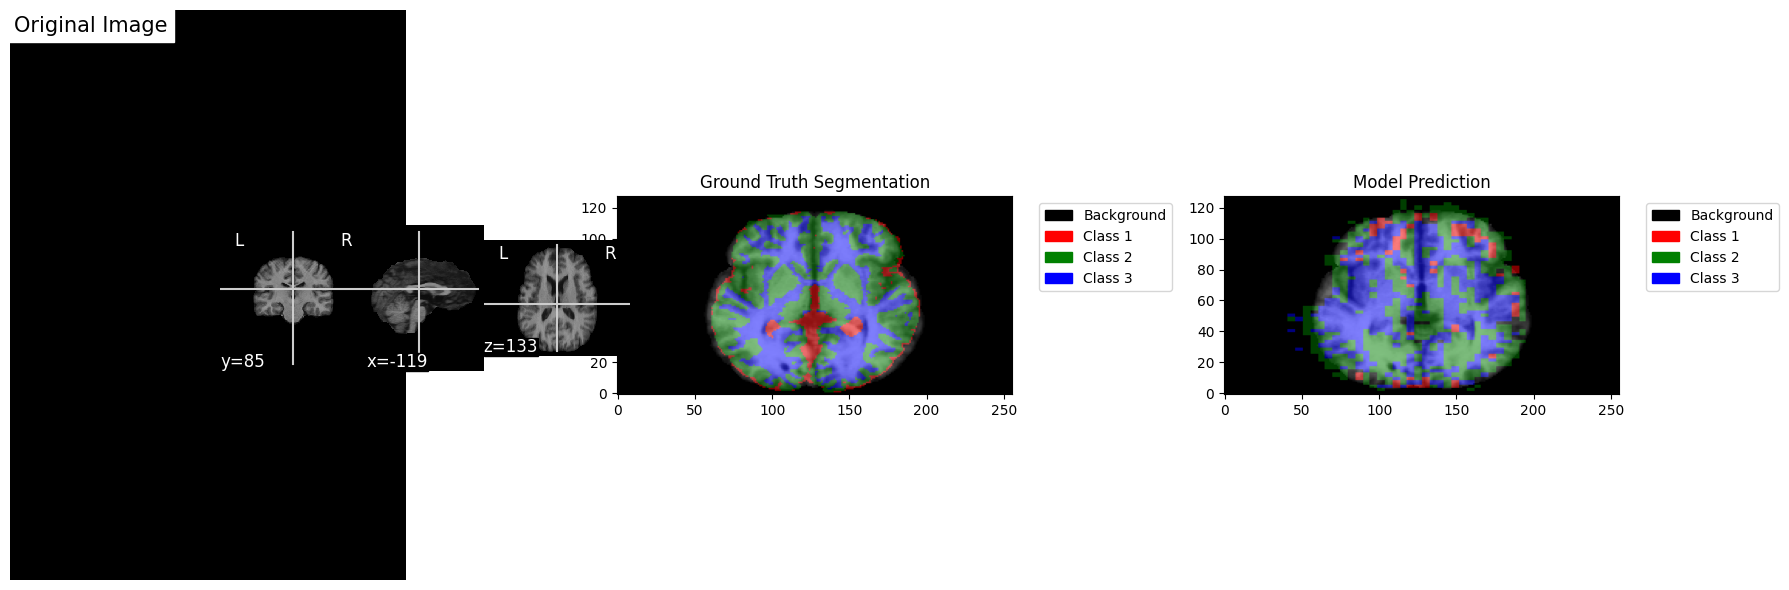

In [41]:
# Get the list of files in each directory
image_files = sorted([f for f in os.listdir(image_path) if f.endswith('.nii')])
label_files = sorted([f for f in os.listdir(label_path) if f.endswith('.nii')])

# Choose a test image 
test_index = 0  # Adjust this based on which image you want to test
test_image_file = image_files[test_index]
test_label_file = label_files[test_index]

# Generate prediction for the test image
test_image_path = os.path.join(image_path, test_image_file)
output_pred_path = 'prediction.nii.gz'

# Save prediction as NIfTI
save_prediction_as_nifti(model, test_image_path, output_pred_path)

# Compare with ground truth
test_label_path = os.path.join(label_path, test_label_file)
visualize_model_predictions(test_image_path, test_label_path, output_pred_path)

In [42]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def visualize_results_multiclass(image_file, label_file, prediction_file):
    """
    Visualize original image, ground truth, and model prediction for 4-class segmentation
    
    Parameters:
    -----------
    image_file : str
        Path to the original NIfTI image
    label_file : str
        Path to ground truth label NIfTI image (values: 0,1,2,3)
    prediction_file : str
        Path to predicted label NIfTI image (values: 0,1,2,3)
    """

    # Load data
    img = nib.load(image_file)
    img_data = img.get_fdata()

    label = nib.load(label_file)
    label_data = label.get_fdata()
    
    pred = nib.load(prediction_file)
    pred_data = pred.get_fdata()

    # Squeeze singleton dimensions if present
    label_data = np.squeeze(label_data).astype(int)
    pred_data = np.squeeze(pred_data).astype(int)

    # Define discrete colormap for 4 classes
    cmap = mcolors.ListedColormap(['black', 'red', 'green', 'blue'])
    class_names = ['Background', 'Class 1', 'Class 2', 'Class 3']

    # Select middle slice index along z-axis
    slice_idx = img_data.shape[2] // 2

    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot original anatomical image
    axes[0].imshow(img_data[:, :, slice_idx].T, cmap='gray', origin='lower')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Plot ground truth segmentation overlay
    axes[1].imshow(img_data[:, :, slice_idx].T, cmap='gray', origin='lower')
    im1 = axes[1].imshow(label_data[:, :, slice_idx].T, cmap=cmap, alpha=0.5, origin='lower', vmin=0, vmax=3)
    axes[1].set_title('Ground Truth')
    axes[1].axis('off')

    # Plot model prediction overlay
    axes[2].imshow(img_data[:, :, slice_idx].T, cmap='gray', origin='lower')
    im2 = axes[2].imshow(pred_data[:, :, slice_idx].T, cmap=cmap, alpha=0.5, origin='lower', vmin=0, vmax=3)
    axes[2].set_title('Model Prediction')
    axes[2].axis('off')

    # Add legend for classes
    import matplotlib.patches as mpatches
    patches = [mpatches.Patch(color=cmap(i), label=class_names[i]) for i in range(4)]
    axes[1].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[2].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


In [43]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from matplotlib.colors import ListedColormap

def visualize_slices(image_file, label_file=None, prediction_file=None):
    """
    Visualize slices with interactive sliders for comparison (for 4 classes)
    
    Parameters:
    -----------
    image_file : str
        Path to the original NIfTI image
    label_file : str, optional
        Path to the ground truth label (with 4 classes: 0,1,2,3)
    prediction_file : str, optional
        Path to the predicted segmentation (with 4 classes)
    """
    # Load data
    img = nib.load(image_file)
    img_data = img.get_fdata()
    
    label_data = None
    if label_file:
        label_img = nib.load(label_file)
        label_data = label_img.get_fdata()
    
    pred_data = None
    if prediction_file:
        pred_img = nib.load(prediction_file)
        pred_data = pred_img.get_fdata()
    
    # Image dimensions
    x_max, y_max, z_max = img_data.shape
    
    # Create figure and axes
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Initial slice index
    z_slice = z_max // 2
    
    # Normalize image for display
    norm_img = (img_data - img_data.min()) / (img_data.max() - img_data.min())
    
    # Define discrete colormap for 4 classes (background + 3 classes)
    # Customize colors as needed
    colors = ['black', 'red', 'green', 'blue']  
    cmap = ListedColormap(colors)
    
    # Show original image
    ax1_img = axes[0].imshow(norm_img[:, :, z_slice], cmap='gray')
    axes[0].set_title('Original Image')
    
    # Show ground truth overlay with discrete colors and alpha blending
    if label_data is not None:
        ax2_img = axes[1].imshow(norm_img[:, :, z_slice], cmap='gray')
        ax2_label = axes[1].imshow(label_data[:, :, z_slice], cmap=cmap, alpha=0.5, vmin=0, vmax=3)
        axes[1].set_title('Ground Truth')
    
    # Show prediction overlay with discrete colors and alpha blending
    if pred_data is not None:
        ax3_img = axes[2].imshow(norm_img[:, :, z_slice], cmap='gray')
        ax3_pred = axes[2].imshow(pred_data[:, :, z_slice], cmap=cmap, alpha=0.5, vmin=0, vmax=3)
        axes[2].set_title('Model Prediction')
    
    # Slider for slice navigation
    ax_z = plt.axes([0.25, 0.01, 0.65, 0.03])
    slider_z = Slider(ax_z, 'Axial Slice', 0, z_max-1, valinit=z_slice, valstep=1)
    
    def update(val):
        z_slice = int(slider_z.val)
        
        ax1_img.set_data(norm_img[:, :, z_slice])
        
        if label_data is not None:
            ax2_img.set_data(norm_img[:, :, z_slice])
            ax2_label.set_data(label_data[:, :, z_slice])
        
        if pred_data is not None:
            ax3_img.set_data(norm_img[:, :, z_slice])
            ax3_pred.set_data(pred_data[:, :, z_slice])
        
        fig.canvas.draw_idle()
    
    slider_z.on_changed(update)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()


### ORGINAL CODE KO ADAPTED VERSION FOR EVALUATION, THOU NOT NECESSARY AS MATHI MAILAY EVAL RAKHI SAKE BUT DIDNT WANT TO REMOVE IT BEFORE STUDYING IT

In [45]:
def evaluate_segmentation(label_file, prediction_file, num_classes=4):
    """
    Evaluate segmentation performance metrics for multi-class segmentation.
    
    Parameters:
    -----------
    label_file : str
        Path to the ground truth label
    prediction_file : str
        Path to the predicted segmentation
    num_classes : int
        Number of classes including background
        
    Returns:
    --------
    dict
        Dictionary containing Dice, IoU, Sensitivity, and Specificity per class
    """
    # Load ground truth and prediction
    true_label = np.squeeze(nib.load(label_file).get_fdata()).astype(int)
    pred_label = np.squeeze(nib.load(prediction_file).get_fdata()).astype(int)

    metrics = {}
    
    for cls in range(num_classes):
        cls_metrics = {}

        # Create binary masks for the current class
        true_cls = (true_label == cls)
        pred_cls = (pred_label == cls)
        
        intersection = np.logical_and(true_cls, pred_cls).sum()
        union = np.logical_or(true_cls, pred_cls).sum()
        true_sum = true_cls.sum()
        pred_sum = pred_cls.sum()

        # Dice Score
        dice = (2.0 * intersection) / (true_sum + pred_sum) if (true_sum + pred_sum) > 0 else 0.0
        # IoU Score
        iou = intersection / union if union > 0 else 0.0
        
        # Sensitivity and Specificity
        true_positive = intersection
        false_negative = true_sum - true_positive
        false_positive = pred_sum - true_positive
        true_negative = true_cls.size - (true_positive + false_negative + false_positive)
        
        sensitivity = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0.0
        specificity = true_negative / (true_negative + false_positive) if (true_negative + false_positive) > 0 else 0.0

        # Store metrics per class
        cls_metrics['dice'] = dice
        cls_metrics['iou'] = iou
        cls_metrics['sensitivity'] = sensitivity
        cls_metrics['specificity'] = specificity

        metrics[f'class_{cls}'] = cls_metrics

    return metrics

### THE FOLLOWING CODE DOES

Loads data (image, label, prediction)

Visualizes them slice-by-slice with interactive sliders

Evaluates multi-class segmentation metrics

Prints the metrics class-wise

THOU NOT NECESSARY FOR US BUT DIDNT WANT TO REMOVE IT

Visualizing results...


C:\Users\Praful\AppData\Local\Temp\ipykernel_31816\2587742128.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


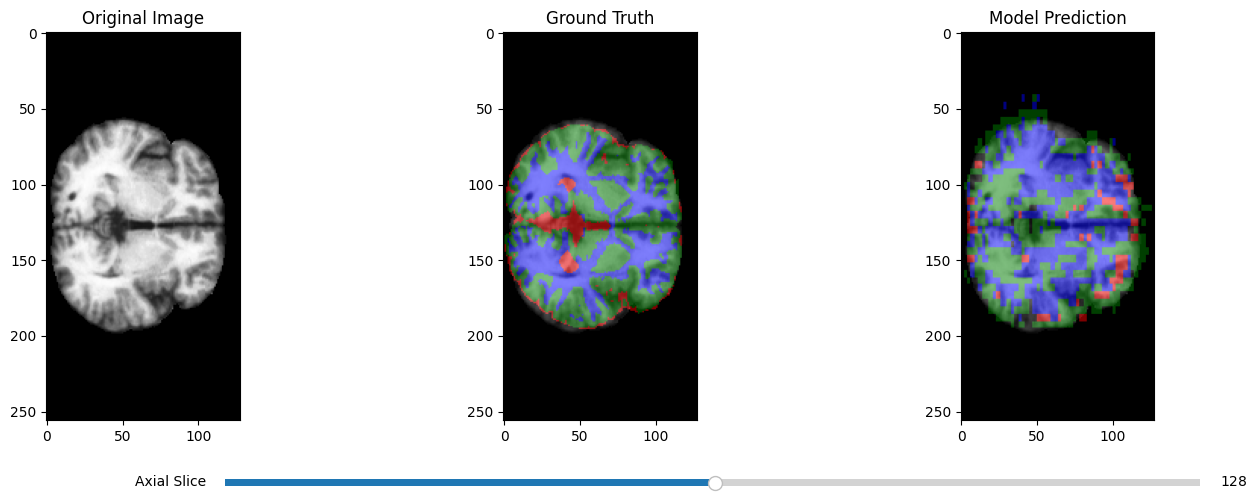


Segmentation Performance Metrics (Per Class):

Class_0:
  Dice: 0.9815
  Iou: 0.9636
  Sensitivity: 0.9742
  Specificity: 0.9176

Class_1:
  Dice: 0.1012
  Iou: 0.0533
  Sensitivity: 0.0963
  Specificity: 0.9882

Class_2:
  Dice: 0.4162
  Iou: 0.2628
  Sensitivity: 0.3925
  Specificity: 0.9659

Class_3:
  Dice: 0.4164
  Iou: 0.2630
  Sensitivity: 0.5340
  Specificity: 0.9586


In [46]:
# Example usage
def run_visualization_example():
    # Paths
    image_files = sorted([os.path.join(image_path, f) for f in os.listdir(image_path) 
                        if f.endswith('.nii') or f.endswith('.nii.gz')])
    label_files = sorted([os.path.join(label_path, f) for f in os.listdir(label_path) 
                        if f.endswith('.nii') or f.endswith('.nii.gz')])
    prediction_file = r"C:\Users\Praful\OneDrive\Desktop\Choreko\prediction.nii.gz"
    
    if not os.path.exists(prediction_file):
        print(f"Prediction file not found: {prediction_file}")
        return
    
    if len(image_files) == 0 or len(label_files) == 0:
        print("No image or label files found!")
        return
    
    # Use the first image and label for visualization
    image_file = image_files[0]
    label_file = label_files[0]
    
    print("Visualizing results...")
    # Uncomment the visualization method you prefer:
    
    # Option 1: nilearn orthogonal view
    #visualize_results(image_file, label_file, prediction_file)
    
    # Option 2: Slice-by-slice visualization with slider
    visualize_slices(image_file, label_file, prediction_file)
    
    # Evaluate performance
    metrics = evaluate_segmentation(label_file, prediction_file)

    # YO BINARY KO LIE HO SO YO COMMENT GARE
    '''
    print("\nSegmentation Performance Metrics:")
    for metric, value in metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")
    '''
    print("\nSegmentation Performance Metrics (Per Class):")
    for cls, cls_metrics in metrics.items():
        print(f"\n{cls.capitalize()}:")
        for metric, value in cls_metrics.items():
            print(f"  {metric.capitalize()}: {value:.4f}")


# Uncomment to run visualization
run_visualization_example()